In [283]:
import pandas as pd
#from GitHub repository
url = "https://raw.githubusercontent.com/robynhathaway/RPDA-PHC-Project/refs/heads/main/PHC_Project_Dataset.csv"
df = pd.read_csv(url)
# df.head()

In [284]:
#updated name to improve consistency in code
df = df.rename(columns={"Distance_PHC (km)": "Distance_PHC_km"})

#log-transform Distance_PHC_km
from sklearn.preprocessing import StandardScaler
import numpy as np

df["log_Distance_PHC_km"] = np.log1p(df["Distance_PHC_km"])
scaler = StandardScaler()
df["log_Distance_PHC_km"] = scaler.fit_transform(df[["log_Distance_PHC_km"]])

In [285]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

df = df.copy()

# Outcome: PHC workload
df['Workload'] = df['PHC_Headcount'] / df['Population']
df = df[np.isfinite(df['Workload']) & (df['Workload'] > 0)].copy()
df['log_Workload'] = np.log(df['Workload'])

# Digital Readiness composite (z-scored components, then average)
digital_cols = [
    'StatsSA_Households_MobileInt (%)',
    'StatsSA_Households_LandCell (%)',
    'StatsSA_Households_PubWIFI (%)',
    'StatsSA_Households_AnyIntAccess (%)'
]

comp = df[digital_cols].astype(float)
comp_z = (comp - comp.mean()) / comp.std(ddof=1)
df['Digital_Readiness'] = comp_z.mean(axis=1)

# give the composite itself SD = 1 for cleaner interpretation
df['Digital_Readiness'] = (
    df['Digital_Readiness'] - df['Digital_Readiness'].mean()
) / df['Digital_Readiness'].std(ddof=1)

# standardise other continuous predictors only
scale_cols = [
    'Med_Pracs_per100k',
    'PHC_Facilities_Total',
    'PHC_Expend_per_capita',
    'Household_Size',
    'log_Distance_PHC_km'
]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Area_Classification as string (Urban, Semi-Urban, Rural)
df['Area_Classification'] = df['Area_Classification'].astype(str)

formula = (
    "log_Workload ~ Digital_Readiness "
    "* C(Area_Classification, Treatment(reference='Urban')) "
    "+ Med_Pracs_per100k + PHC_Facilities_Total "
    "+ PHC_Expend_per_capita + Household_Size "
    "+ log_Distance_PHC_km"
)

model_df = df[['log_Workload', 'Digital_Readiness', 'Med_Pracs_per100k',
               'PHC_Facilities_Total', 'PHC_Expend_per_capita',
               'Household_Size', 'log_Distance_PHC_km',
               'Area_Classification', 'Province']].dropna().copy()

model = smf.mixedlm(
    formula=formula,
    data=model_df,
    groups=model_df["Province"],  
    re_formula="1"                # random intercepts: each province has its own unobserved baseline workload level
)

result = model.fit(reml=True, method="lbfgs", maxiter=200)
print(result.summary())



                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        log_Workload
No. Observations:                        156                            Method:                                    REML        
No. Groups:                              9                              Scale:                                     0.0324      
Min. group size:                         9                              Log-Likelihood:                            11.5563     
Max. group size:                         33                             Converged:                                 Yes         
Mean group size:                         17.3                                                                                  
-------------------------------------------------------------------------------------------------------------------------------
                     

In [286]:
import numpy as np

# Get list of fixed-effect parameter names
names = list(result.fe_params.index)

# Automatically find the interaction term names
term_rural = [n for n in names
              if "Digital_Readiness:C(Area_Classification" in n and "Rural" in n][0]
term_semi = [n for n in names
             if "Digital_Readiness:C(Area_Classification" in n and "Semi" in n][0]

print("Using interaction terms:")
print("  Rural term:", term_rural)
print("  Semi term:", term_semi)

def t_linear_combo(weights):
    """
    weights: dict mapping param_name -> coefficient in the linear combo.
             e.g. {'Digital_Readiness': 1, term_rural: 1}
    """
    R = np.zeros((1, len(names)))
    for pname, w in weights.items():
        idx = names.index(pname)
        R[0, idx] = w
    return result.t_test(R)   # now R is a proper contrast vector


# Urban slope = Digital_Readiness
test_urban = t_linear_combo({'Digital_Readiness': 1})

# Rural slope = Digital_Readiness + Digital_Readiness × Rural
test_rural = t_linear_combo({
    'Digital_Readiness': 1,
    term_rural: 1
})

# Semi-urban slope = Digital_Readiness + Digital_Readiness × Semi-Urban
test_semi = t_linear_combo({
    'Digital_Readiness': 1,
    term_semi: 1
})

print("\nUrban slope test:")
print(test_urban)

print("\nRural slope test:")
print(test_rural)

print("\nSemi-urban slope test:")
print(test_semi)


Using interaction terms:
  Rural term: Digital_Readiness:C(Area_Classification, Treatment(reference='Urban'))[T.Rural]
  Semi term: Digital_Readiness:C(Area_Classification, Treatment(reference='Urban'))[T.Semi-Urban]

Urban slope test:
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1142      0.077      1.488      0.137      -0.036       0.265

Rural slope test:
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1853      0.063      2.950      0.003       0.062       0.308

Semi-urban slope test:
                             Test for Constraints                             
          

In [287]:
# Separate ML refit for model fit indices (AIC/BIC)
result_ml = model.fit(reml=False, method="lbfgs", maxiter=200)

print("\nModel Fit Statistics (ML)")
print("----------------------------")
print(f"AIC: {result_ml.aic:.2f}")
print(f"BIC: {result_ml.bic:.2f}")
print(f"Log-Likelihood: {result_ml.llf:.2f}")



Model Fit Statistics (ML)
----------------------------
AIC: -47.96
BIC: -8.32
Log-Likelihood: 36.98


In [288]:
# Model Diagnostics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# check for multicollinearity (VIFs)
X = model_df[['Digital_Readiness','Med_Pracs_per100k','PHC_Expend_per_capita',
              'Household_Size','log_Distance_PHC_km']]
X = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)

                Variable       VIF
0                  const  1.000000
1      Digital_Readiness  1.858434
2      Med_Pracs_per100k  1.493610
3  PHC_Expend_per_capita  2.234643
4         Household_Size  1.271949
5    log_Distance_PHC_km  1.048655


/Users/RobynH/Desktop/Varsity VC Code/Research_Project/venv/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


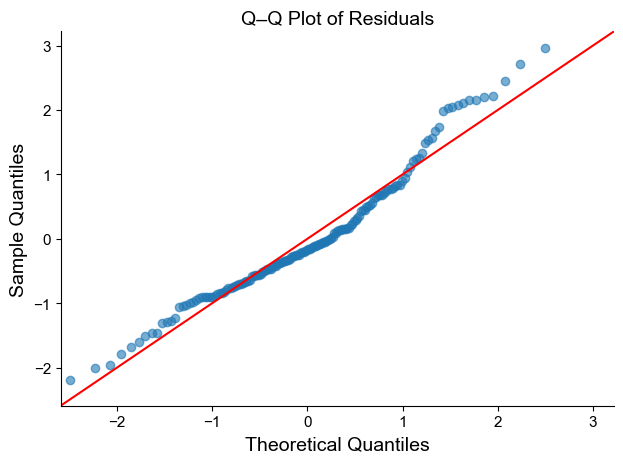

In [289]:
# residual normality Q-Q plot

import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"

resid = result.resid
fig = sm.qqplot(resid, line="45", fit=True, color="#2B6CB0", alpha=0.6)

ax = plt.gca()
ax.set_facecolor("white")
ax.grid(False)

ax.set_title("Q–Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=14)
ax.set_ylabel("Sample Quantiles", fontsize=14)

for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


In [290]:
#Marginal and Conditional R squared

import numpy as np
import pandas as pd

# Fixed-effects linear predictor variance: Var(X beta)
X = result.model.exog                
beta = result.fe_params.values
var_fix = np.var(X @ beta, ddof=1)

# Residual variance (sigma^2)
var_resid = result.scale

# Random-effects variance components
# Statsmodels MixedLM stores RE variances in cov_re; residual scale in result.scale
cov_re = result.cov_re               # DataFrame; intercept at [0,0]
var_intercept = float(cov_re.iloc[0, 0]) if cov_re is not None else 0.0


var_slope = 0.0
if cov_re is not None and cov_re.shape[0] > 1:
    var_slope = float(cov_re.iloc[1, 1])


var_random = var_intercept + var_slope 
var_total  = var_fix + var_random + var_resid

R2_marginal    = var_fix / var_total
R2_conditional = (var_fix + var_random) / var_total

print(f"Marginal R^2 (fixed):     {R2_marginal:.3f}")
print(f"Conditional R^2 (fixed+RE): {R2_conditional:.3f}")


Marginal R^2 (fixed):     0.218
Conditional R^2 (fixed+RE): 0.708


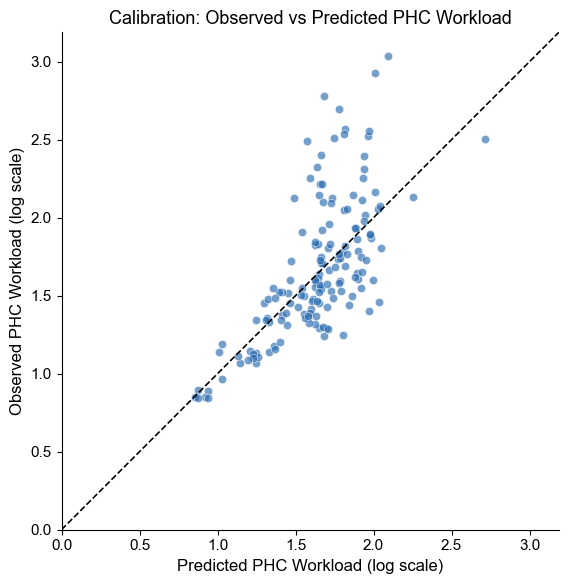

In [ ]:
# Model Calibration
import numpy as np
import matplotlib.pyplot as plt

# Extract fitted and observed (on log scale)
fitted_log = result.fittedvalues
obs_log = model_df["log_Workload"]

# Convert back to original scale
predicted = np.exp(fitted_log)
observed = np.exp(obs_log)

# plotting
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"
ax = plt.gca()
ax.set_facecolor("white")

# Scatter plot
plt.scatter(predicted, observed,
            alpha=0.65,
            color="#2B6CB0",
            edgecolor="white",
            linewidth=0.5)

# Ensure equal aspect ratio for 45° line
mx = max(predicted.max(), observed.max()) * 1.05
plt.plot([0, mx], [0, mx], color="black", linestyle="--", linewidth=1.2)
plt.xlim(0, mx)
plt.ylim(0, mx)
ax.set_aspect('equal', adjustable='box')

# Labels and title

plt.xlabel("Predicted PHC Workload (log scale)")
plt.ylabel("Observed PHC Workload (log scale)")
plt.title("Calibration: Observed vs Predicted PHC Workload")

# Style
ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


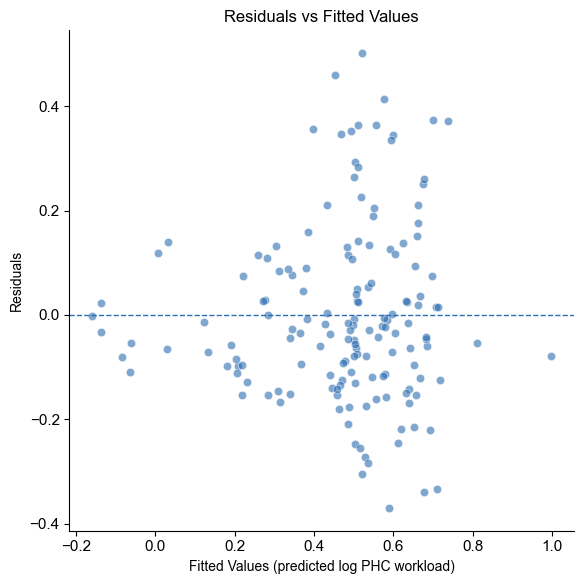

In [292]:
#residuals vs fitted values

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"

ax = plt.gca()
ax.set_facecolor("white")

plt.scatter(result.fittedvalues, result.resid, alpha=0.6,
            color="#2B6CB0", edgecolor="white", linewidth=0.5)
plt.axhline(0, color="#2B6CB0", linestyle="--", linewidth=1)

plt.title("Residuals vs Fitted Values", fontsize=12)
plt.xlabel("Fitted Values (predicted log PHC workload)", fontsize=10)
plt.ylabel("Residuals", fontsize=10)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


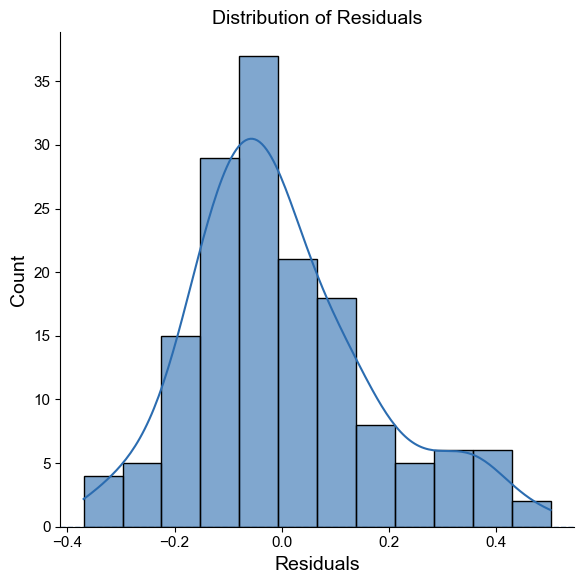

In [293]:
# Distribution of Residuals

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Arial"

ax = plt.gca()
ax.set_facecolor("white")

sns.histplot(result.resid, kde=True, color="#2B6CB0", alpha=0.6, ax=ax)
plt.axhline(0, color="#2B6CB0", linestyle="--", linewidth=1)

plt.title("Distribution of Residuals", fontsize=14)
plt.xlabel("Residuals", fontsize=14)
plt.ylabel("Count", fontsize=14)

ax.grid(False)
for spine in ax.spines.values():
    spine.set_color("black")

plt.tight_layout()
plt.show()


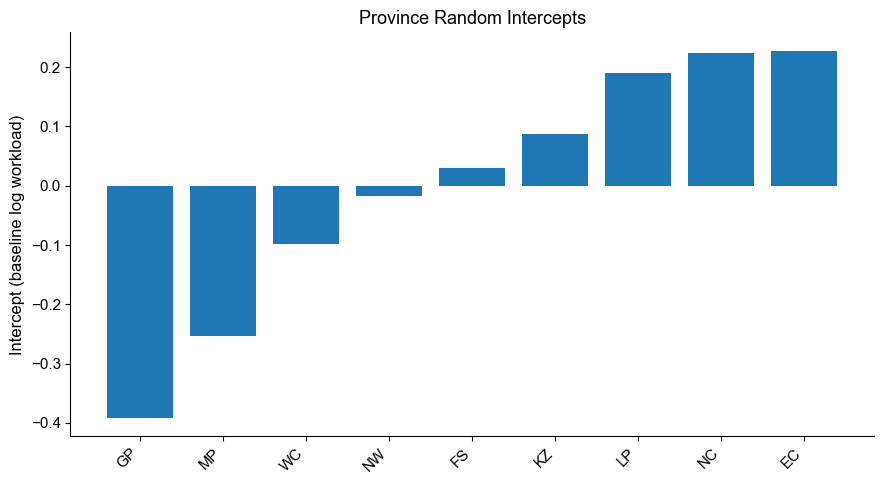

In [294]:
# Results/ Visualisations:
#province level random intercepts

# Convert random effects dict to DataFrame
re = pd.DataFrame.from_dict(result.random_effects, orient='index')
re.index.name = 'Province'
re = re.reset_index()

# Statsmodels often names the intercept 'Intercept' or 'const'
intercept_cols = [c for c in re.columns if c.lower() in ['intercept','const']]
slope_cols = [c for c in re.columns if 'Digital_Readiness' in c]

# Fallback if names are odd
if not intercept_cols:
    intercept_cols = [re.columns[1]]
if not slope_cols and re.shape[1] >= 3:
    slope_cols = [re.columns[2]]

# Bar plot of random intercepts by province
plt.figure(figsize=(9,5))
re_sorted = re.sort_values(intercept_cols[0])
plt.bar(re_sorted['Province'], re_sorted[intercept_cols[0]])
plt.title("Province Random Intercepts")
plt.ylabel("Intercept (baseline log workload)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

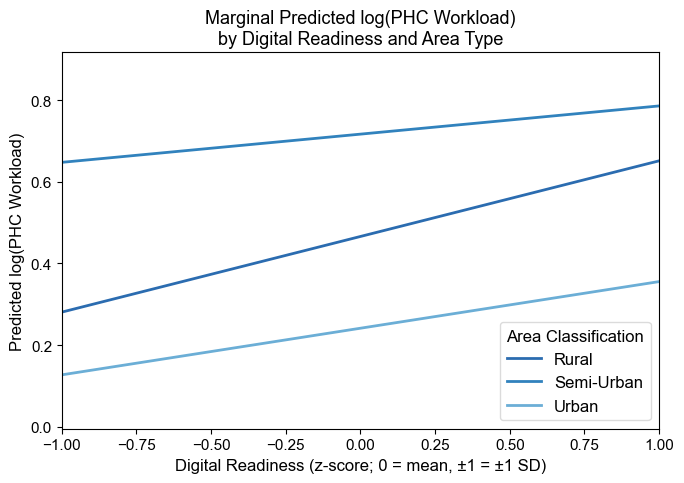

In [295]:
#marginal predicted phc workload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.weight": "normal",
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

# symmetric SD range for clearer interpretation
dr_vals = np.linspace(-1, 1, 100)


# Area levels (Urban, Semi-Urban, Rural)
area_levels = sorted(
    model_df["Area_Classification"].dropna().unique().tolist()
)


rows = []
for area in area_levels:
    tmp = pd.DataFrame({
        "Digital_Readiness": dr_vals,
        "Area_Classification": area,
        "Med_Pracs_per100k": 0.0,
        "PHC_Facilities_Total": 0.0,
        "PHC_Expend_per_capita": 0.0,
        "Household_Size": 0.0,
        "log_Distance_PHC_km": 0.0,
    })

    tmp["Area_Classification"] = tmp["Area_Classification"].astype(
        model_df["Area_Classification"].dtype
    )
   

    tmp["Pred_log"] = result.predict(tmp)
    tmp["Area"] = area
    rows.append(tmp)

grid = pd.concat(rows, ignore_index=True)

#plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_facecolor("white")

color_map = {
    "Rural": "#2B6CB0",
    "Semi-Urban": "#3182bd",
    "Urban": "#6baed6",
}

for area in area_levels:
    sub = grid[grid["Area"] == area]
    ax.plot(
        sub["Digital_Readiness"],
        sub["Pred_log"],
        label=area,
        color=color_map.get(area, None),
        linewidth=2,
    )

# X axis
x_min, x_max = dr_vals.min(), dr_vals.max()
ax.set_xlim(-1, 1)


# Y axis
y_min, y_max = grid["Pred_log"].min(), grid["Pred_log"].max()
y_range = y_max - y_min
ax.set_ylim(y_min - 0.2 * y_range, y_max + 0.2 * y_range)

ax.grid(False)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")

# axis labels 
ax.set_xlabel("Digital Readiness (z-score; 0 = mean, ±1 = ±1 SD)")
ax.set_ylabel("Predicted log(PHC Workload)")
ax.set_title("Marginal Predicted log(PHC Workload)\nby Digital Readiness and Area Type")

legend = ax.legend(title="Area Classification")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("lightgrey")

fig.tight_layout()
plt.show()
